# CS5242

## Load Data

In [1]:
from data import Data
import numpy as np

full_train = Data(data_type='train')

# idx = np.random.permutation(len(full_train.x))
# full_train_x,full_train_y = full_train.x[idx], full_train.y[idx]
full_train_x,full_train_y = full_train.x, full_train.y


del full_train

val_data_x, train_data_x = full_train_x[:full_train_x.shape[0]//5,:], full_train_x[full_train_x.shape[0]//5:,:]
val_data_y,train_data_y = full_train_y[:full_train_y.shape[0]//5,:], full_train_y[full_train_y.shape[0]//5:,:]

print("Train data: x:"+ str(train_data_x.shape)+ ' y:'+str(train_data_y.shape))
print("Validation data: x:"+ str(val_data_x.shape)+ ' y:'+str(val_data_y.shape))



Loading train data 18662/18662: 100%|█████████████████████████████████████████████████████████████ [ time left: 00:00 ]


Train data: x:(14930, 1000, 102) y:(14930, 1)
Validation data: x:(3732, 1000, 102) y:(3732, 1)


## Model

In [2]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

model_name = 'boosting_conv1d_lstm'

def create_model(show_summary = False):
    model = tf.keras.Sequential([
        # tf.keras.layers.Permute((2, 1), input_shape=(1000, 102)),
        # tf.keras.layers.Conv1D(filters=16,kernel_size=4,strides=4,activation='relu')
        # tf.keras.layers.Reshape((-1,400,), input_shape=(None,None,25,16)),
        # 
        tf.keras.layers.Reshape(target_shape=(1000,102,1),input_shape=(1000,102)),

        tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(filters=8,kernel_size=4,strides=4),input_shape=(1000,102,1)),
        # tf.keras.layers.Conv1D(filters=128,kernel_size=4,strides=4,data_format="channels_first",input_shape=(1000,102)),
        tf.keras.layers.Reshape(target_shape=(1000,8*25)),

        # tf.keras.layers.LSTM(128,return_sequences=True),
        tf.keras.layers.LSTM(64,return_sequences=True),
        tf.keras.layers.LSTM(32),


    #     tf.keras.layers.Dropout(rate=0.5),
        tf.keras.layers.Dense(32, activation='relu'),
        # tf.keras.layers.Dropout(rate=0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
])

    model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(2e-4),
              metrics=['accuracy',tf.keras.metrics.AUC()])
    
    if show_summary:
        model.summary()
    
    return model
    
num_of_bags = 10
epochs_per_bag = 200
start_from_bag = 0


## Training with Boosting

Training bag 0
[1. 1. 1. ... 1. 1. 1.]
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 1000, 102, 1)      0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1000, 25, 8)       40        
_________________________________________________________________
reshape_3 (Reshape)          (None, 1000, 200)         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1000, 64)          67840     
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)

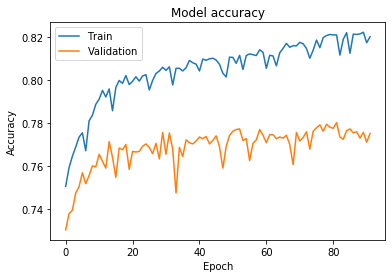

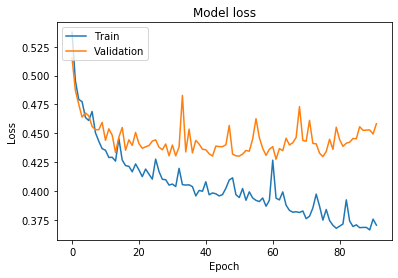

Training bag 1
(14930, 1)
(14930,)
[0.66822535 0.33177471 0.33177465 ... 0.33177471 0.21136862 0.08613324]


Loading test data 6051/6051: 100%|████████████████████████████████████████████████████████████████ [ time left: 00:00 ]


In [ ]:
import os
import matplotlib.pyplot as plt
import csv
import math
from data import Data

%matplotlib inline
    
training_loss = np.ones(train_data_x.shape[0])

for bag in range(num_of_bags):
    # skip training
    if bag < start_from_bag:
        print("skiping bag "+str(bag))
        continue
    print("Training bag "+str(bag))

    # Put data into bags
    model = create_model(False)
    train_size = train_data_x.shape[0]//10*7
    if bag != 0 :
        # Check prediction for training data
        for validate_bag in range(bag):
            checkpoint_dir = './checkpoints/' + model_name+ '_bag'+ str(validate_bag)
            model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
            if validate_bag == 0:
                predictions = model.predict(train_data_x)
            else:
                predictions = np.concatenate((predictions,model.predict(train_data_x)),axis=1)
        print(predictions.shape)

        avg_predictions = np.mean(predictions, axis=1)
        print(avg_predictions.shape)
        
        # Select training data poorly predicted 
        training_loss = avg_predictions-np.reshape(train_data_y,(train_data_y.shape[0]))
        training_loss = np.absolute(training_loss)
        print(training_loss)
        
        # Save Predictions for test data
        test_data = Data(data_type='test')
        for validate_bag in range(bag):
            checkpoint_dir = './checkpoints/' + model_name+ '_bag'+ str(validate_bag)
            model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
            if validate_bag == 0:
                predictions = model.predict(test_data.x)
            else:
                predictions = np.concatenate((predictions,model.predict(test_data.x)),axis=1)
        print(predictions.shape)

        avg_predictions = np.mean(predictions, axis=1)
        print(avg_predictions.shape)
        
        output_file = 'result_' + model_name +'_boost'+ str(bag) +'.csv'
        with open(output_file, 'wt', newline='', encoding='utf-8') as output_file:
            csv_writer = csv.writer(output_file)
            csv_writer.writerow(('Id', 'Predicted'))
            for id, predict in enumerate(avg_predictions):
                csv_writer.writerow((id, predict))
        print('Saved to '+'result_' + model_name +'_boost'+ str(bag) +'.csv')
        # Free memory space for test data
        del test_data
        
        
    
    idx = (-training_loss).argsort()[:train_size]
    print(training_loss[idx])
    bag_x,bag_y = train_data_x[idx], train_data_y[idx]
        
    del model
        
    ## TODO define different models if possible
    model = create_model(bag==0)
    # Directory where the checkpoints will be saved
    checkpoint_dir = './checkpoints/' + model_name+ '_bag'+ str(bag)
    # Name of the checkpoint files
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

    checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_prefix,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True)

    early_stopping_callback = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        min_delta=0, 
        patience=30, 
        mode='auto', 
        restore_best_weights=True)
        
        
        
    history = model.fit(x=bag_x,y=bag_y, validation_data=(val_data_x,val_data_y), epochs=epochs_per_bag,batch_size=32,
                    callbacks=[checkpoint_callback,early_stopping_callback], verbose=2,shuffle=True)
    
    print()
    
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    
    del model,history,bag_x,bag_y
    

## Restore Weights

In [ ]:
checkpoint_dir = './checkpoints/' + model_name
model = create_model()

import numpy as np
from data import Data

test_data = Data(data_type='test')
print("Test data: x:"+ str(test_data.x.shape)+ ' y:'+str(test_data.y.shape))

for bag in range(num_of_bags):
    checkpoint_dir = './checkpoints/' + model_name+ '_bag'+ str(bag)
    model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
    if bag == 0:
        predictions = model.predict(test_data.x)
    else:
        predictions = np.concatenate((predictions,model.predict(test_data.x)),axis=1)
print(predictions.shape)

avg_predictions = np.mean(predictions, axis=1)
print(avg_predictions.shape)



## Save Prediction to CSV

In [ ]:
import csv

output_file = 'result_' + model_name + '.csv'
with open(output_file, 'wt', newline='', encoding='utf-8') as output_file:
    csv_writer = csv.writer(output_file)
    csv_writer.writerow(('Id', 'Predicted'))
    for id, predict in enumerate(avg_predictions):
        csv_writer.writerow((id, predict))
print('Saved to '+'result_' + model_name + '.csv')